In [1]:
# !pip install tensorflow-datasets
!pip install -U tfds-nightly
# !pip install tensorflow-gpu

Requirement already up-to-date: tfds-nightly in /home/jupyter/.local/lib/python3.7/site-packages (3.2.1.dev202008120105)


In [2]:
# !pip install -U --pre tensorflow=="2.1"
!pip install tf_slim

In [3]:
!pip install pycocotools

In [4]:
# !pip install tensorflow==2.1


In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display



In [6]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [7]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto:5:1: warning: Import object_detection/protos/image_resizer.proto is unused.


In [8]:
%%bash 
cd models/research
pip install .

Processing /home/jupyter/hazard-detection/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1310302 sha256=8d894d40511e0c122bca7ae08894aa41c34416bdefd5db5182885ff96d65e5d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfd50y0j/wheels/2f/69/68/d174ba7c18fe52ba5ad48455b812a18ad3d77a17bed688d8be
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [9]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [10]:
import tensorflow_datasets as tfds


In [11]:
# ds = tfds.load('kitti', split='train',data_dir='/content/tensorflow_datasets', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
# print(ds)

In [12]:
# !gcloud auth login application-default



In [13]:
!gcloud config set account application-default

Updated property [core/account].


In [14]:
# from google.colab import auth
# auth.authenticate_user()

In [15]:
# !gcloud auth login dissertation-0




In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
#     shuffle_files=True,
    # as_supervised=True,
#     try_gcs=True,
    with_info=True,
    download=False,
#     data_dir='./tensorflow_datasets'
    data_dir="gs://kitti-dataset-1"
)

# ds = tfds.load('kitti', split='train',data_dir='/content/tensorflow_datasets')


In [17]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [18]:

# model_name = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'
# model_name = 'ssd_inception_v2_coco_2018_01_28'
model_name = 'faster_rcnn_resnet50_lowproposals_coco_2018_01_28'
# model_name = 'faster_rcnn_resnet101_kitti_2018_01_28'
# model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
# model_name = 'faster_rcnn_nas_lowproposals_coco_2018_01_28'
detection_model = load_model(model_name)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [19]:
# List of the strings that is used to add correct label for each box.

# PATH_TO_LABELS = 'models/research/object_detection/data/kitti_label_map.pbtxt'
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


In [20]:
# ds_train =ds 

In [21]:
def normalize_img(object):
  print(object['objects'])
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(object['image'], tf.float32) / 255., object['objects']['bbox']



In [22]:
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
ds_train

<PrefetchDataset shapes: {image: (None, None, 3), image/file_name: (), objects: {alpha: (None,), bbox: (None, 4), dimensions: (None, 3), location: (None, 3), occluded: (None,), rotation_y: (None,), truncated: (None,), type: (None,)}}, types: {image: tf.uint8, image/file_name: tf.string, objects: {alpha: tf.float32, bbox: tf.float32, dimensions: tf.float32, location: tf.float32, occluded: tf.int64, rotation_y: tf.float32, truncated: tf.float32, type: tf.int64}}>

In [24]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
print(detection_model.inputs)



[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [26]:
detection_model.output_dtypes

{'detection_scores': tf.float32,
 'num_detections': tf.float32,
 'detection_classes': tf.float32,
 'detection_boxes': tf.float32}

In [27]:
detection_model.output_shapes

{'detection_scores': TensorShape([None, 20]),
 'num_detections': TensorShape([None]),
 'detection_classes': TensorShape([None, 20]),
 'detection_boxes': TensorShape([None, 20, 4])}

In [28]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [29]:
def norm(data):
    height= 375
    width = 1242
    
    data['xmin'] = data['xmin'] / width 
    data['xmax'] = data['xmax'] / width
    data['ymin'] = (height - data['ymin']) / height
    data['ymax'] = (height - data['ymax']) / height
    
    return data

In [57]:
import pandas as pd
import numpy as np
import time

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from tqdm.keras import TqdmCallback



# ----------- import data and scaling ----------- #
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

X_train = df_train[['xmin', 'xmax', 'ymin' ,'ymax']]
y_train = df_train[['xloc', 'yloc','zloc']].values

X_test = df_test[['xmin', 'xmax', 'ymin','ymax']].values
y_test = df_test[['xloc', 'yloc','zloc']].values

#  ymin=(height - bbox.bottom) / height,
#       ymax=(height - bbox.top) / height,
#       xmin=bbox.left / width,
#       xmax=bbox.right / width,
# 375 ,1242
# standardized data
# xScalar = StandardScaler()
# yScalar = StandardScaler()
# X_train = xScalar.fit_transform(X_train)
# y_train = yScalar.fit_transform(y_train)

X_train = norm(X_train).values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [31]:
# X_train = df_train[['xmin', 'xmax', 'ymin' ,'ymax']].values

print(X_train[:10])

# X_train = norm(X_train)
# X_train[:10]


[[0.57326892 0.65217391 0.61866667 0.18133333]
 [0.48228663 0.50644122 0.584      0.496     ]
 [0.3115942  0.34057971 0.51733333 0.45866667]
 [0.647343   0.80112721 0.55466667 0.128     ]
 [0.52898551 0.56360709 0.49333333 0.40533333]
 [0.49436393 0.58534622 0.51733333 0.24266667]
 [0.22544283 0.27697262 0.50666667 0.42666667]
 [0.29388084 0.32689211 0.50933333 0.45333333]
 [0.26570048 0.28985507 0.52533333 0.36533333]
 [0.44122383 0.4605475  0.544      0.48266667]]


In [58]:
# TRAINING MODE


# ----------- create model ----------- #
model = keras.Sequential()
model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(150, kernel_initializer='normal', activation='relu'))
model.add(Dense(150, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal'))


# opt = tf.keras.optimizers.Adam(
#     learning_rate=0.001
# )
# model = multi_gpu_model(model, gpus=2)
model.compile(loss='mean_squared_error',optimizer='adam')

# ----------- define callbacks ----------- #
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7,
                verbose=1, min_delta=1e-4, mode='min')
modelname = "model@{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir="logs/{}".format(modelname))

# ----------- start training ----------- #
history = model.fit(X_train, y_train,
            validation_split=0.1, epochs=10000, batch_size=8000,verbose=0, callbacks=[tensorboard, TqdmCallback(verbose=1)])


# ----------- save model and weights ----------- #
model_json = model.to_json()
with open("generated_files/{}.json".format(modelname), "w") as json_file:
   json_file.write(model_json)

model.save_weights("generated_files/{}.h5".format(modelname))
print("Saved model to disk")




Saved model to disk


In [33]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-uh2n2m7f
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-uh2n2m7f
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.081c920d61a6b3bf209346e49cb3b253caac43cfb_-py3-none-any.whl size=125856 sha256=e764a4af1bf8ee09128fbb767a63c1dbee714000378a6addba1df035bd40cb08
  Stored in directory: /tmp/pip-ephem-wheel-cache-ucd959e0/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
  Attempting uninstall: tensorflow-docs
    Found existing installation: tensorflow-docs 0.0.04364f1819084bb1afeb618e9a615b63b45a1e726-
    Uninstalling tensorflow-docs-0.0.04364f1819084bb1afeb618e9a615b63b45a1e726-:
      Successfully uninstalled tensorflow-docs-0.0.04364f1819084bb1afeb618e9a615b63b45a1e726-
Note: you may need to restart the kernel to use updated packages.


In [34]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
9995,7.144378,7.323655,9995
9996,7.126755,7.251665,9996
9997,7.079965,7.150198,9997
9998,7.042021,7.196096,9998
9999,7.101249,7.087691,9999


In [36]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


In [37]:
plotter.plot({'Basic': history}, metric = "loss")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

plt.show()

In [38]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [59]:
# INFERENCE MODE

from tensorflow.keras.models import model_from_json

df_test = pd.read_csv('data/test.csv')
X_test = df_test[['xmin', 'xmax', 'ymin','ymax']]
y_test = df_test[['xloc' ,'yloc','zloc']].values

# standardized data
# scalar = MinMaxScaler()
# X_test = scalar.fit_transform(X_test)
# y_test = yScalar.fit_transform(y_test)
    
X_test = norm(X_test).values
print(X_test[:10])

# MODEL = "model@1595813111"
# WEIGHTS = "model@1595813111"

MODEL = modelname
WEIGHTS = modelname


# load json and create model
json_file = open('generated_files/{}.json'.format(MODEL), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json( loaded_model_json )

# load weights into new model
loaded_model.load_weights("generated_files/{}.h5".format(WEIGHTS))
print("Loaded model from disk")

# loaded_model = model
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
y_pred = loaded_model.predict(X_test)


# scale up predictions to original values
# y_pred_transformed = yScalar.inverse_transform(y_pred)
# y_test_transformed = yScalar.inverse_transform(y_test)

# y_pred_transformed = y_pred
# save predictions
df_result = df_test
df_result['zloc_pred'] = -100000
df_result['xloc_pred'] = -100000


for idx, row in df_result.iterrows():
    df_result.at[idx, 'zloc_pred'] = y_pred[idx][2]
    df_result.at[idx, 'xloc_pred'] = y_pred[idx][0]

df_result.to_csv('data/predictions2.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

[[0.54428341 0.55394525 0.56533333 0.48533333]
 [0.48148148 0.52495974 0.52533333 0.41866667]
 [0.52254428 0.53462158 0.552      0.45066667]
 [0.82206119 0.88647343 0.64533333 0.15733333]
 [0.85024155 0.99919485 0.49333333 0.00266667]
 [0.58293076 0.64814815 0.52533333 0.336     ]
 [0.0958132  0.2962963  0.624      0.38666667]
 [0.49194847 0.51771337 0.56533333 0.47466667]
 [0.37520129 0.42028986 0.50933333 0.448     ]
 [0.23027375 0.27133655 0.47733333 0.41333333]]
Loaded model from disk


In [60]:

def run_locnet( bboxes):
  
    print( bboxes)
#     bboxes = xScalar.transform(bboxes)
    y_pred = loaded_model.predict(bboxes)
    # scale up predictions to original values
#     y_pred_transformed = yScalar.inverse_transform(y_pred)

    return y_pred
#     return y_pred_transformed

In [41]:
def filter_detections( output_dict):
    
    output_dict['detection_boxes'] = np.array([ output_dict['detection_boxes'][i] for i in range(len(output_dict['detection_boxes'])) if output_dict['detection_scores'][i] > 0.5 and output_dict['detection_classes'][i] in (1,3)  ])
    output_dict['detection_classes'] = np.array([ output_dict['detection_classes'][i] for i in range(len(output_dict['detection_boxes'])) if output_dict['detection_scores'][i] > 0.5 and output_dict['detection_classes'][i] in (1,3)  ])

    return output_dict

In [55]:
def process_image(image):
  

    image_np = np.copy(image) #TODO: make more efficent 
    
    output_dict = run_inference_for_single_image(detection_model, image_np)
    # Visualization of the results of a detection.
#     print(output_dict)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=1)
    
#     print("output_dict_before:" ,output_dict)

    output_dict =filter_detections( output_dict)
#     print("output_dict" ,output_dict)
    locations = run_locnet( output_dict['detection_boxes'])
    
 
    
    print( "distance_vector")

    print( locations)
#     vis_util.draw_bounding_box_on_image_array(image_np, xmin, ymin, xmax, ymax, thickness=1, display_str_list=[distance])
    
    return image_np

In [61]:
run_locnet( [[0.41085333,0.4335749 ,0.5223467 ,0.4712963 ]])

[[0.41085333, 0.4335749, 0.5223467, 0.4712963]]


array([[-0.50845635,  0.76372063,  1.726992  ]], dtype=float32)

In [44]:

# Load the TensorBoard notebook extension
# %reload_ext tensorboard


%tensorboard --logdir logs


UsageError: Line magic function `%tensorboard` not found.


In [ ]:
%reload_ext tensorboard

In [ ]:
!pip install tensorboard 

In [49]:
def show_inference(model, tensor):
  
  
    image_np = np.array(tensor)
    image =process_image(image_np)
    display(Image.fromarray(image))
    return

In [ ]:
# df = tfds.as_dataframe(ds_train.take(10), ds_info)

In [ ]:
# df

In [ ]:
ds_numpy = tfds.as_numpy(ds_train.take(10))

In [ ]:
for ex in ds_numpy:
  # `{'image': np.array(shape=(28, 28, 1)), 'labels': np.array(shape=())}`
  print(ex)

['image', 'image/file_name', 'objects']
(375, 1242, 3)
tf.Tensor([[0.41085333 0.4335749  0.5223467  0.4712963 ]], shape=(1, 4), dtype=float32)
location: tf.Tensor([[-1.77  1.66 26.96]], shape=(1, 3), dtype=float32)
[[0.48387626 0.43768257 0.58862966 0.47398788]]
distance_vector
[[-0.08195951 -0.19530532  1.9101237 ]]


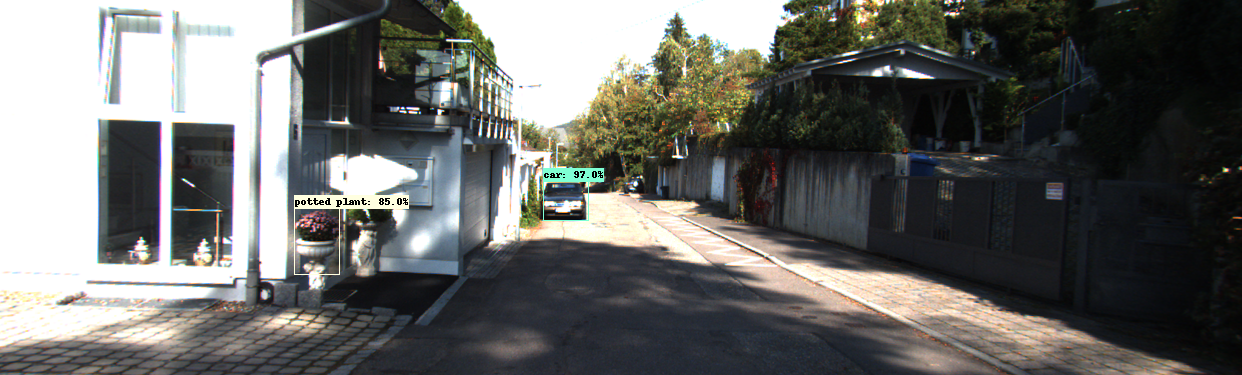

['image', 'image/file_name', 'objects']
(376, 1241, 3)
tf.Tensor(
[[0.4419415  0.4600161  0.52037233 0.48607576]
 [0.00265957 0.         0.46289894 0.24649476]
 [0.3025266  0.14333601 0.50678194 0.26334408]
 [0.3668085  0.23475423 0.5086968  0.31551167]
 [0.33260638 0.2977921  0.64654255 0.39928284]
 [0.41691488 0.38484287 0.5100532  0.42310235]
 [0.44101062 0.4031265  0.50851065 0.4305963 ]
 [0.32460105 0.05693795 0.5128989  0.18574537]], shape=(8, 4), dtype=float32)
location: tf.Tensor(
[[ -1.21   1.33  41.37]
 [ -4.82   1.62   7.06]
 [ -8.1    1.56  16.71]
 [ -8.29   1.5   22.67]
 [ -4.59   1.51  19.8 ]
 [ -4.66   1.39  31.76]
 [ -5.39   1.41  42.98]
 [-11.46   1.55  18.29]], shape=(8, 3), dtype=float32)
[[0.53940815 0.         0.9943958  0.24312885]
 [0.49397543 0.45765543 0.5695299  0.48794532]
 [0.49874336 0.15145287 0.67452246 0.25724834]
 [0.50942    0.24032071 0.63856083 0.29516235]
 [0.4966944  0.39720145 0.58782375 0.419333  ]
 [0.49755853 0.06267206 0.57674104 0.1647056 ]
 

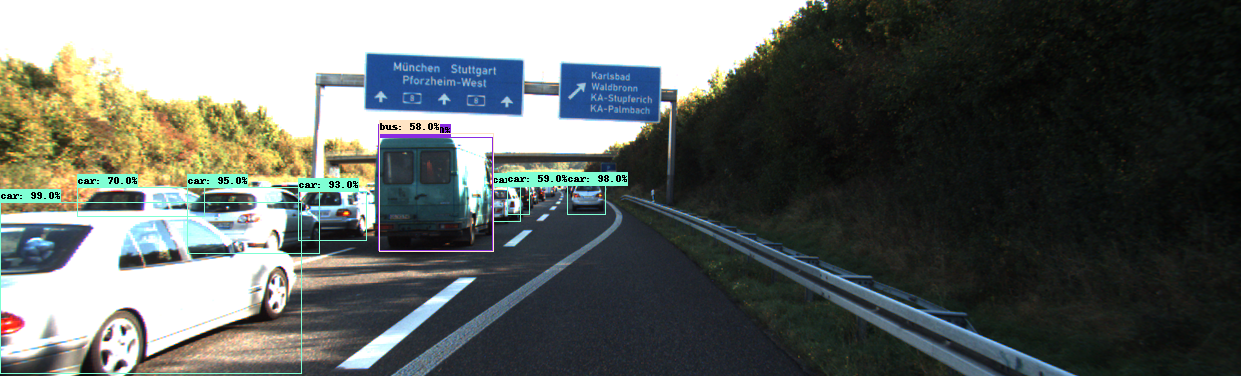

['image', 'image/file_name', 'objects']
(375, 1242, 3)
tf.Tensor(
[[0.48896    0.5000725  0.5954667  0.5558535 ]
 [0.23117334 0.02500805 0.48733333 0.20439613]
 [0.41389334 0.7859823  0.5932267  0.8263446 ]], shape=(3, 4), dtype=float32)
location: tf.Tensor(
[[ 4.02  1.7  71.99]
 [-9.46  2.06 15.06]
 [10.76  1.25 19.96]], shape=(3, 3), dtype=float32)
[[0.52162343 0.0287208  0.7495469  0.19711593]
 [0.41951883 0.80022466 0.5691587  0.82226646]
 [0.4768984  0.2913467  0.54140794 0.32672873]
 [0.4395767  0.6495108  0.52557534 0.65756696]
 [0.43850285 0.64772797 0.5250343  0.655233  ]
 [0.43875915 0.6411834  0.5222097  0.6490214 ]]
distance_vector
[[-0.15888336 -0.19039711 -0.969309  ]
 [-1.7559478  -7.0355506   8.019011  ]
 [-0.06909659 -0.15959796 -0.5309187 ]
 [-0.7982509  -6.013491    6.339832  ]
 [-0.7897823  -5.990932    6.3080745 ]
 [-0.7684332  -6.0291467   6.2403836 ]]


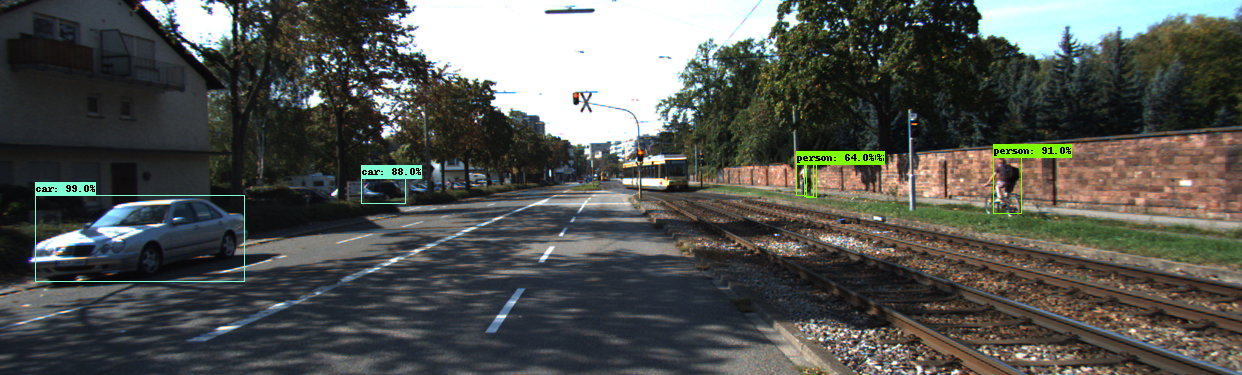

['image', 'image/file_name', 'objects']
(375, 1242, 3)
tf.Tensor([[0.5062133  0.5752093  0.54509336 0.58990335]], shape=(1, 4), dtype=float32)
location: tf.Tensor([[11.63  1.23 73.79]], shape=(1, 3), dtype=float32)
[]


UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [62]:
for example in ds_test.take(10):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    objects = example["objects"]
  
    print( image.shape)
    print(objects['bbox'])
    print('location:', objects['location'])
    show_inference(detection_model, image)




In [ ]:
ds_info

In [63]:
#Evaluation Steps


from object_detection import eval_util
from object_detection.core import standard_fields as fields
from object_detection.metrics import coco_evaluation
from object_detection.protos import eval_pb2
from object_detection.utils import test_case
from object_detection.utils import tf_version

def test_get_eval_metric_ops_for_coco_detections(eval_dict, batch_size=1,
                                               max_gt_boxes=None,
                                               scale_to_absolute=False):
    eval_config = eval_pb2.EvalConfig()
    eval_config.metrics_set.extend(['pascal_voc_detection_metrics'])
    categories = list(category_index.values())

    metric_ops = eval_util.get_eval_metric_ops_for_evaluators(
        eval_config, categories, eval_dict)
    _, update_op = metric_ops['DetectionBoxes_Precision/mAP']

    with self.test_session() as sess:
        metrics = {}
        for key, (value_op, _) in six.iteritems(metric_ops):
            metrics[key] = value_op
        sess.run(update_op)
        metrics = sess.run(metrics)
        print(metrics)
  

In [66]:
#TODO: Complete Evaluation steps

input_data_fields = fields.InputDataFields
detection_fields = fields.DetectionResultFields

for example in ds_test.take(1):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(list(example.keys()))
    image = example["image"]
    objects = example["objects"]
  
#     print( objects)
    print(objects['location'])
#     show_inference(detection_model, image)
    image_np = np.array(image)
    # Actual detection.
    output_dict = run_inference_for_single_image(detection_model, image_np)
    
#       return eval_util.result_dict_for_single_example(
#           image, key, detections, groundtruth,
#           scale_to_absolute=scale_to_absolute)


#     batch_size = 100
#     key = tf.constant([str(i) for i in range(batch_size)])

    key = tf.constant('image1')
    
    groundtruth_boxes = tf.constant(objects['bbox'])
    groundtruth_classes = tf.constant(objects['type'])
    groundtruth = {
        input_data_fields.groundtruth_boxes: groundtruth_boxes,
        input_data_fields.groundtruth_classes: groundtruth_classes,
      
    }
    
#     num_detections = tf.convert_to_tensor([len(output_dict['detection_classes'])])
    batch_size = 1
    num_detections = tf.ones([batch_size])
    detections = {
        detection_fields.detection_boxes: tf.tile(tf.constant([output_dict['detection_boxes']]), multiples=[batch_size, 1 ,1]) ,
        detection_fields.detection_scores: tf.tile(tf.constant([output_dict['detection_scores']]), multiples=[batch_size, 1]) ,
        detection_fields.detection_classes: tf.tile(tf.constant([output_dict['detection_classes']]), multiples=[batch_size, 1]) ,
        detection_fields.num_detections: num_detections
       
    }
    
    
    result_dict = eval_util.result_dict_for_single_example(image, key,detections, groundtruth,scale_to_absolute=False)
#     test_get_eval_metric_ops_for_coco_detections(output_dict)

['image', 'image/file_name', 'objects']
tf.Tensor([[-1.77  1.66 26.96]], shape=(1, 3), dtype=float32)


ValueError: Dimensions 1 and 375 are not compatible

In [ ]:
objects['type']

In [ ]:
!pip install moviepy proglog

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
# !gsutil cp gs://hazard-detection-test-videos/accident_compilation.mp4 accident_compilation.mp4

In [ ]:
!ls -sh accident_compilation.mp4

In [ ]:
from moviepy.editor import VideoFileClip
import proglog
proglog.notebook()

write_output = 'output_' + model_name + '.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first n seconds
# clip1 = VideoFileClip("test.mp4").subclip(0,1)

# clip1 = VideoFileClip("test.mp4")

clip1 = VideoFileClip("accident_compilation.mp4")


white_clip = clip1.fl_image(process_image) 

white_clip.write_videofile(write_output, audio=False, verbose=False)

clip1.close()


In [ ]:
# import os
# os.environ['PYTHONPATH'] += ":/content/models"

# import sys
# sys.path.append("/content/models")

!pip install tf-models-official --user

In [ ]:
# !python models/research/object_detection/legacy/eval.py --pipeline_config_path=gs://hazard-detection-test-videos/job_dir/pipeline.config  --checkpoint_dir=gs://hazard-detection-test-videos/job_dir --eval_dir=gs://hazard-detection-test-videos/eval_dir

In [ ]:
!python models/research/object_detection/model_main.py --pipeline_config_path=pipeline.config  --checkpoint_dir=checkpoint_dir --model_dir=eval_dir
            
            
            
            
            

In [ ]:
# !gsutil cp gs://hazard-detection-test-videos/tf2model/* ./

In [ ]:
!ls checkpoint_dir

## LocNet starts
